In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yaml
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

/data/rsg/nlp/sdobers/miniconda3/envs/diffdock_protein/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir('/data/rsg/nlp/sdobers/ruslan/diffdock-protein/src')

from args import parse_args
from data import load_data, get_data
from data.data import BindingDataset
from model import load_model, to_cuda
from utils import printt, print_res, log, get_unixtime, compute_rmsd
from train import train, evaluate, evaluate_pose
from helpers import WandbLogger, TensorboardLogger
from sample import sample

In [4]:
CUDA_VISIBLE_DEVICE = 6
torch.cuda.set_device(CUDA_VISIBLE_DEVICE)
print(torch.cuda.is_available())

True


In [5]:
PATH = '/data/rsg/nlp/sdobers/ruslan/diffdock-protein/ckpts/dips_medium_model/'

In [6]:
class Dict2Class:
    def __init__(self, my_dict):
        for key in my_dict:
            setattr(self, key, my_dict[key])

In [7]:
# load args
with open(os.path.join(PATH, 'args.yaml')) as f:
    args = yaml.safe_load(f)
args['num_gpu'] = 2
args['gpu'] = CUDA_VISIBLE_DEVICE
args = Dict2Class(args)
args.data_file = args.data_file.replace('data_file', 'data_file_only_val')

In [8]:
args.data_file

'/data/rsg/nlp/sdobers/data/DIPS/data_file_only_val.csv'

In [9]:
# load raw data
data = load_data(args)
data_params = data.data_params

data loading:   0%| | 1/985 [00:00<00:00, 10782.27


1280
10:10:23 Loaded cached ESM embeddings
10:10:23 finished tokenizing residues with ESM
10:10:23 finished tokenizing all inputs
10:10:23 2 entries loaded


In [10]:
val_dataset = BindingDataset(args, data.data)
val_dataset_without_noise = BindingDataset(args, data.data, apply_transform=False)

In [11]:
import os
import sys
import copy

import numpy as np
import torch
from torch_geometric.loader import DataLoader, DataListLoader
from scipy.spatial.transform import Rotation as R

from utils import printt
from geom_utils import set_time, NoiseTransform
from sample import *

In [12]:
val_dataset_randomized = randomize_position(val_dataset_without_noise, args)

In [13]:
# if torch.cuda.is_available() and args.num_gpu > 1:
#     loader = DataListLoader
# else:
#     loader = DataLoader
test_loader = DataLoader(val_dataset_randomized, batch_size=1)

In [14]:
complex_graphs = None
for complex_graphs_i in test_loader:
    complex_graphs = complex_graphs_i
    break

In [15]:
complex_graphs

HeteroDataBatch(
  name=[1],
  center=[1, 3],
  receptor={
    pos=[409, 3],
    x=[409, 1281],
    batch=[409],
    ptr=[2]
  },
  ligand={
    pos=[112, 3],
    x=[112, 1281],
    batch=[112],
    ptr=[2]
  },
  (receptor, contact, receptor)={ edge_index=[2, 8180] },
  (ligand, contact, ligand)={ edge_index=[2, 2240] }
)

In [16]:
transform = NoiseTransform(args)
timesteps = get_timesteps(args.num_steps)

In [17]:
cur_t = timesteps[0]
cur_t

1.0

In [18]:
tr_s, rot_s, tor_s = transform.noise_schedule(cur_t, cur_t, cur_t)
tr_s

30.0

In [19]:
device_for_set_time = complex_graphs["ligand"]["pos"].device if torch.cuda.is_available() and args.num_gpu == 1 else None
device_for_set_time

In [20]:
type(complex_graphs)

torch_geometric.data.batch.HeteroDataBatch

In [21]:
set_time(complex_graphs, cur_t, cur_t, cur_t, 1, device_for_set_time)

In [22]:
import os
import sys
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from e3nn import o3
from e3nn.nn import BatchNorm
from torch_cluster import radius, radius_graph
from torch_scatter import scatter, scatter_mean

from geom_utils import NoiseSchedule, score_norm

from model.diffusion import *

In [23]:
args.checkpoint_path = PATH

In [24]:
# get model and load checkpoint, if relevant
model = load_model(args, data_params, 0)
model = to_cuda(model, args)

/data/rsg/nlp/sdobers/miniconda3/envs/diffdock_protein/lib/python3.10/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


10:10:26 loaded model with kwargs: 
10:10:26 loaded checkpoint from /data/rsg/nlp/sdobers/ruslan/diffdock-protein/ckpts/dips_medium_model/fold_0/model_best_385432_306_0.541_0.541.pth


In [25]:
complex_graphs_cuda = complex_graphs.cuda()

In [26]:
complex_graphs[0]["ligand", "ligand"].edge_index

tensor([[  1,  65,  66,  ...,   0, 101,  97],
        [  0,   0,   0,  ..., 111, 111, 111]], device='cuda:6')

In [27]:
complex_graphs[0]["receptor", "receptor"].edge_index

tensor([[  1,   3,   2,  ..., 401, 394, 202],
        [  0,   0,   0,  ..., 408, 408, 408]], device='cuda:6')

In [28]:
if args.dynamic_max_cross:
    cross_cutoff = (tr_s * 3 + 40)
else:
    cross_cutoff = args.cross_max_dist

In [29]:
ligand_graph = model.module.encoder.build_rigid_graph(complex_graphs, "ligand")
receptor_graph = model.module.encoder.build_rigid_graph(complex_graphs, "receptor")

In [30]:
cross_edge_index, cross_edge_attr, cross_edge_sh = model.module.encoder.cross_conv_graph(
            complex_graphs.cuda(), cross_cutoff
        )

In [31]:
complex_graphs["ligand", "contact", "receptor"].edge_index = cross_edge_index

In [32]:
complex_graphs

HeteroDataBatch(
  name=[1],
  center=[1, 3],
  complex_t={
    tr=[1],
    rot=[1],
    tor=[1]
  },
  receptor={
    pos=[409, 3],
    x=[409, 1281],
    batch=[409],
    ptr=[2],
    node_t={
      tr=[409],
      rot=[409],
      tor=[409]
    },
    node_sigma_emb=[409, 32]
  },
  ligand={
    pos=[112, 3],
    x=[112, 1281],
    batch=[112],
    ptr=[2],
    node_t={
      tr=[112],
      rot=[112],
      tor=[112]
    },
    node_sigma_emb=[112, 32]
  },
  (receptor, contact, receptor)={ edge_index=[2, 8180] },
  (ligand, contact, ligand)={ edge_index=[2, 2240] },
  (ligand, contact, receptor)={ edge_index=[2, 45808] }
)

In [33]:
cross_edge_index[0].unique(return_counts=True)

(tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111],
        device='cuda:6'),
 tensor([409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409,
         409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409,
         409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409,
         409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409,
         409, 409, 409, 4

In [34]:
cross_edge_index

tensor([[  0,   0,   0,  ..., 111, 111, 111],
        [  0,   1,   2,  ..., 406, 407, 408]], device='cuda:6')

In [51]:
import torch_geometric
from matplotlib import pyplot as plt
import networkx as nx

In [52]:
g = torch_geometric.utils.to_networkx(complex_graphs.to_homogeneous(), to_undirected=False)

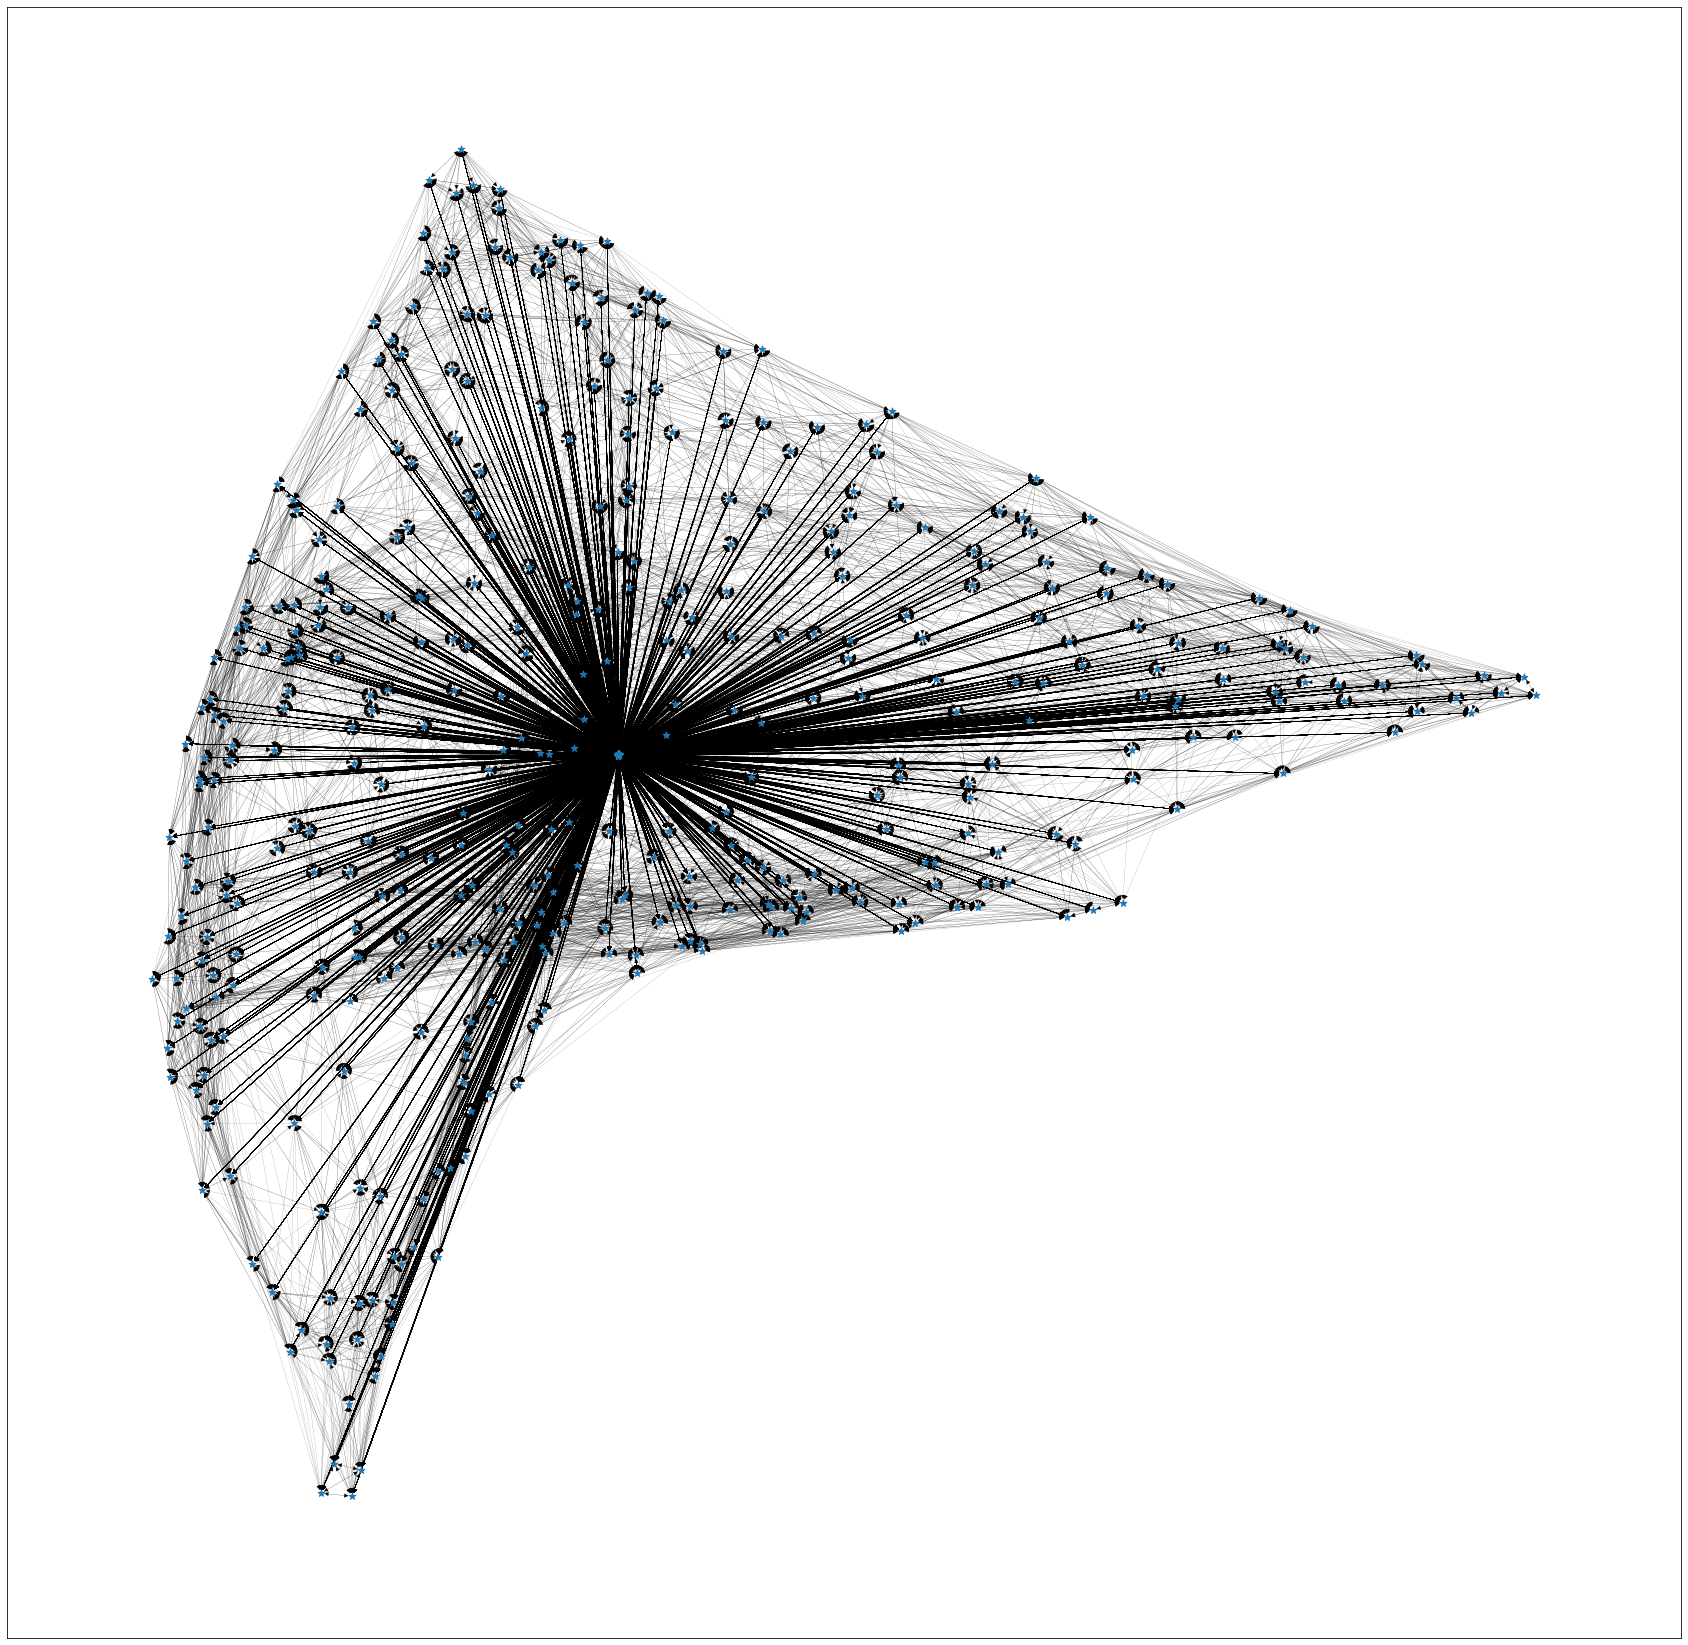

In [53]:
plt.figure(figsize=(30, 30))
nx.draw_networkx(g, with_labels=False, node_shape='*', node_size=50, width=0.1)

In [39]:
complex_graphs_copy = copy.copy(complex_graphs)
del complex_graphs_copy["ligand", "contact", "receptor"]

In [ ]:
g_copy = torch_geometric.utils.to_networkx(complex_graphs_copy.to_homogeneous(), to_undirected=False)

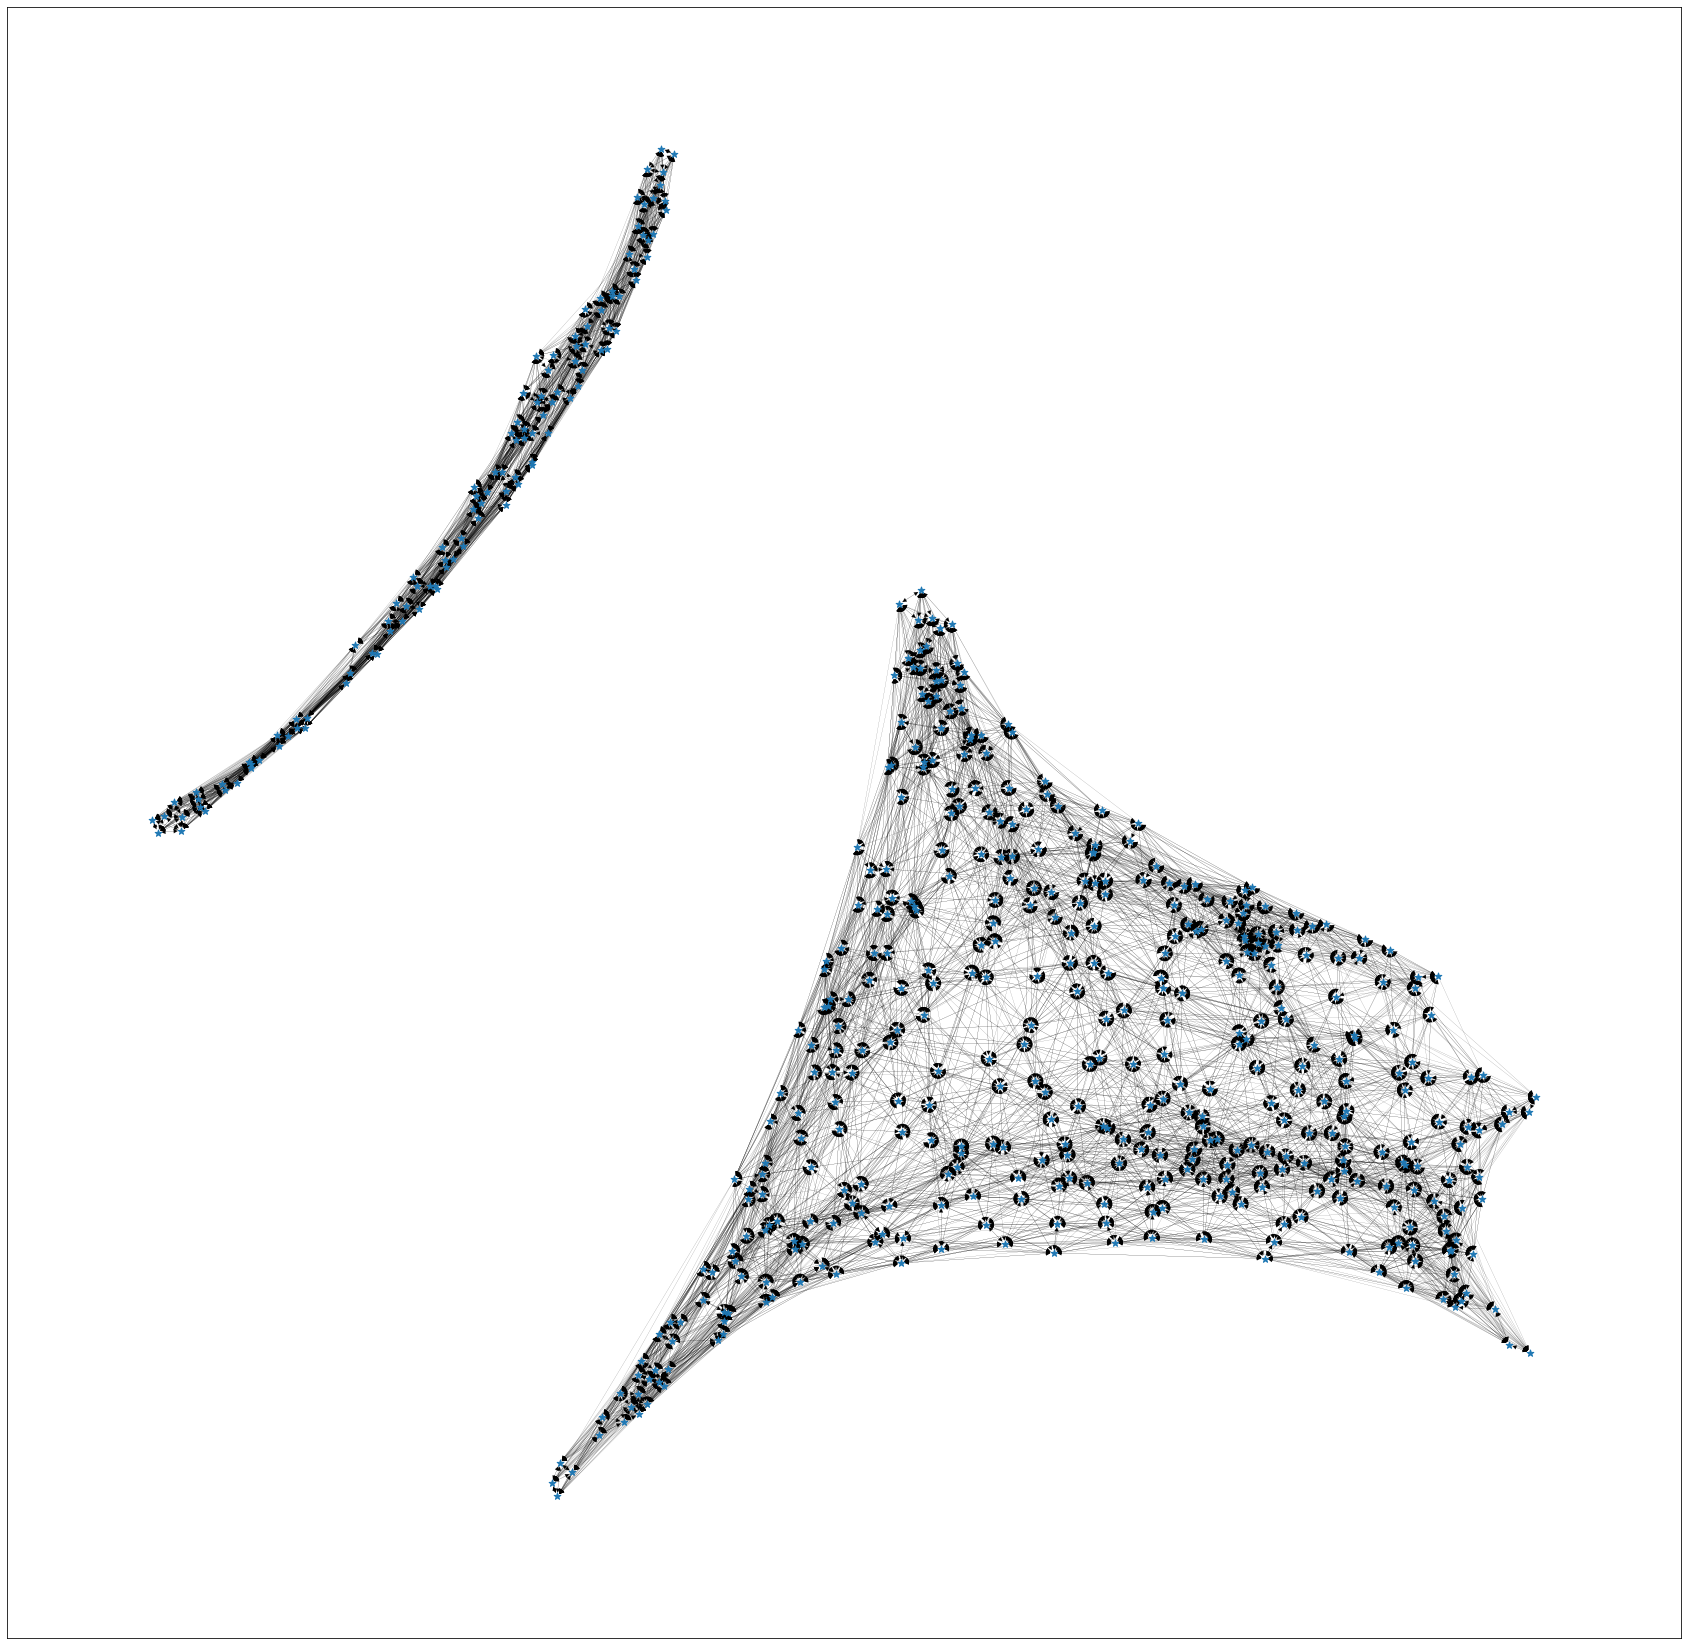

In [49]:
plt.figure(figsize=(30, 30))
nx.draw_networkx(g_copy, with_labels=False, node_shape='*', node_size=50, width=0.1)